In [1]:
import numpy as np
import pandas as pd
import pickle
import project_tools as tools
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [32]:
original_stats, original_games, original_records, original_teams, original_spread, original_rankings = tools.load_data_pkl()

In [33]:
original_spread

,season,seasonType,week,gameId,homeTeam,awayTeam,spread,homeWinProb
0,2013,regular,1,332432005,Air Force,Colgate,-31.5,0.968
1,2013,regular,1,332420012,Arizona,Northern Arizona,-35.0,0.980
2,2013,regular,1,332430008,Arkansas,Louisiana,-14.0,0.795
3,2013,regular,1,332432032,Arkansas State,Arkansas-Pine Bluff,-17.5,0.848
4,2013,regular,1,332420349,Army,Morgan State,-31.0,0.966
...,...,...,...,...,...,...,...,...
6111,2020,regular,16,401260158,Tennessee,Texas A&M,13.5,0.214
6112,2020,regular,16,401269376,UCLA,Stanford,-6.5,0.649
6113,2020,regular,16,401249434,USC,Oregon,-3.0,0.570
6114,2020,regular,16,401269375,Utah,Washington State,-11.5,0.751


In [57]:
spreads = tools.get_games_df('train')

In [59]:
spreads

,gameId,spread,homeWinProb
0,332432005,31.5,0.968
1,332420012,35.0,0.980
2,332430008,14.0,0.795
3,332432032,17.5,0.848
4,332420349,31.0,0.966
...,...,...,...
6111,401260158,-13.5,0.214
6112,401269376,6.5,0.649
6113,401249434,3.0,0.570
6114,401269375,11.5,0.751


## Single Variable Linear Regression

In [5]:
pd.options.display.max_columns = None
train = games[games['season'] < 2018]
valid = games[games['season'] == 2018]

X_train = train['home_wins'].to_numpy() - train['away_wins'].to_numpy()
y_train = train['result'].to_numpy()

X_valid = valid['home_wins'].to_numpy() - valid['away_wins'].to_numpy()
y_valid = valid['result'].to_numpy()

In [113]:
pd.options.display.max_columns = None
train = games[games['season'] < 2018]
valid = games[games['season'] == 2018]

X_train = train['totalYards_spread'].to_numpy()
y_train = train['result'].to_numpy()

X_valid = valid['totalYards_spread'].to_numpy()
y_valid = valid['result'].to_numpy()

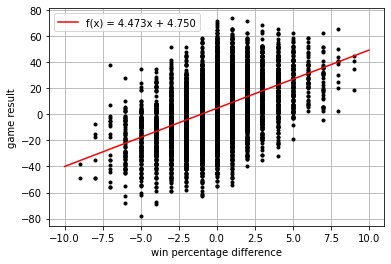

In [7]:
baseline_model = LinearRegression().fit(X_train.reshape(-1, 1), y_train)

x = np.linspace(-10, 10, 500)
y = baseline_model.coef_[0] * x + baseline_model.intercept_

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(X_train, y_train, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_[0], baseline_model.intercept_))
plt.legend()
plt.grid()

In [8]:
prediction_train = baseline_model.predict(X_train.reshape(-1, 1))
prediction_valid = baseline_model.predict(X_valid.reshape(-1, 1))
print('RMSE on train = %.2f points' % mean_squared_error(y_train, prediction_train, squared=False))
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, prediction_valid, squared=False))

RMSE on train = 18.97 points
RMSE on valid = 19.74 points


## Ridge Regression Baseline

In [24]:
X= games.drop(['home_team','away_team','result'], axis=1).to_numpy()
y = games['result']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

In [25]:
LinRegMod = LinearRegression()
LinRegMod.fit(X_train, y_train)

LinearRegression()

In [26]:
pred_train = LinRegMod.predict(X_train)
print('RMSE on train = %.2f points' % mean_squared_error(y_train, pred_train, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_train)==np.sign(y_train))/len(y_train)*100:.4}%\n')

pred_valid = LinRegMod.predict(X_valid)
print('RMSE on valid = %.2f points' % mean_squared_error(y_valid, pred_valid, squared=False))
print(f'Percent Correct (W/L) = {np.sum(np.sign(pred_valid)==np.sign(y_valid))/len(y_valid)*100:.4}%')

RMSE on train = 17.56 points
Percent Correct (W/L) = 70.88%

RMSE on valid = 17.90 points
Percent Correct (W/L) = 70.05%


## Playing around with a Neural Net

In [163]:
torch.manual_seed(0)
device = torch.device("cpu")
print('Using device', device)

Using device cpu


In [164]:
# Prepare Data
X_train = torch.tensor(games.drop(['home_team','away_team','result'], axis=1).to_numpy())
y_train = torch.tensor(games['result'])
print(y.size())
print(X.size())

torch.Size([10458])
torch.Size([10458, 36])


In [181]:
train_in = games.drop(columns=['home_team','away_team','result'])
train_out = games.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy(), dtype=torch.float, device=device)

data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

In [211]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(36, 1)       
        
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.h1(x)
        return x
    
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False, log_freq = 10):
    for epoch in range(epochs):
        model.train()
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        if verbose & (epoch%log_freq==0):
            print('Train Epoch: %d  \tLoss: %.6f' % (epoch, loss.item()/len(data)))
model = Network()

In [231]:
model = nn.Sequential(nn.Linear(36,1))

In [264]:
BATCH_SIZE = 10458
EPOCHS = 100
LEARNING_RATE = 0.0000001
MOMENTUM = 0.00005

In [265]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [266]:
train(model, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jhrag/opt/anaconda3/envs/ee511/lib/python3.9/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 0  	Loss: 14.141275
Train Epoch: 10  	Loss: 27.226220
Train Epoch: 20  	Loss: 14.480957
Train Epoch: 30  	Loss: 14.313484
Train Epoch: 40  	Loss: 23.511364
Train Epoch: 50  	Loss: 24.157180
Train Epoch: 60  	Loss: 11.251363
Train Epoch: 70  	Loss: 18.246010
Train Epoch: 80  	Loss: 15.482465
Train Epoch: 90  	Loss: 12.670204


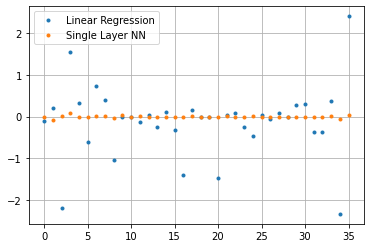

In [267]:
nn_weights = model[0].weight.detach().numpy().T
lreg_weights = LinRegMod.coef_

plt.plot(lreg_weights, '.')
plt.plot(nn_weights, '.')
plt.grid()
plt.legend(['Linear Regression','Single Layer NN'])